In [4]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [9]:
# Load the dataset
df = pd.read_csv('../../../csv/Beras.csv')

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tanggal                   678 non-null    object
 1   Luas Panen Padi           678 non-null    int64 
 2   GKP Tingkat Petani        678 non-null    int64 
 3   GKP Tingkat Penggilingan  678 non-null    int64 
 4   GKG Tingkat Penggilingan  678 non-null    int64 
 5   Harga Beras Penggilingan  678 non-null    int64 
 6   Produksi Beras            678 non-null    int64 
 7   Harga Beras               678 non-null    int64 
 8   UMP                       678 non-null    int64 
 9   BBM Solar                 678 non-null    int64 
 10  Tingkat Konsumsi          678 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 58.4+ KB


(      Tanggal  Luas Panen Padi  GKP Tingkat Petani  GKP Tingkat Penggilingan  \
 0  2021-03-15               10                4000                      4150   
 1  2021-03-16               10                3850                      4100   
 2  2021-03-17               10                4160                      4230   
 3  2021-03-18               10                4120                      4190   
 4  2021-03-19               10                4190                      4290   
 
    GKG Tingkat Penggilingan  Harga Beras Penggilingan  Produksi Beras  \
 0                      5050                      9465           14419   
 1                      4740                      9360           14419   
 2                      4950                      9400           14419   
 3                      4730                      9340           14419   
 4                      4990                      9410           14419   
 
    Harga Beras   UMP  BBM Solar  Tingkat Konsumsi  
 0        112

In [10]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Year'] = df['Tanggal'].dt.year
df['Month'] = df['Tanggal'].dt.month

In [11]:
data_mod = df.drop(columns=['Tanggal'])

X = data_mod.drop('Harga Beras', axis=1)
y = data_mod['Harga Beras']

In [12]:
# Convert each column of X and y to a separate pandas Series with a DatetimeIndex
X_series = {col: pd.Series(X[col].values, index=pd.date_range(start='2022-01-01', periods=len(X))) for col in X.columns}
y_series = pd.Series(y.values, index=pd.date_range(start='2022-01-01', periods=len(y)))

# Now you can decompose each series in X_series
decomposition_train = {col: sm.tsa.seasonal_decompose(series, model='additive', period=7) for col, series in X_series.items()}
decomposition_test = sm.tsa.seasonal_decompose(y_series, model='additive', period=7)

# Collect the components for train data
train_trend = {col: decomposition.trend.dropna() for col, decomposition in decomposition_train.items()}
train_seasonal = {col: decomposition.seasonal.dropna() for col, decomposition in decomposition_train.items()}
train_residual = {col: decomposition.resid.dropna() for col, decomposition in decomposition_train.items()}

# Collect the components for test data
test_trend = decomposition_test.trend.dropna()
test_seasonal = decomposition_test.seasonal.dropna()
test_residual = decomposition_test.resid.dropna()

# Display the components for train data
for col in train_trend:
    print(f"{col} trend:\n{train_trend[col].head()}\n")
    print(f"{col} seasonal:\n{train_seasonal[col].head()}\n")
    print(f"{col} residual:\n{train_residual[col].head()}\n")

Luas Panen Padi trend:
2022-01-04    11.428571
2022-01-05    15.714286
2022-01-06    20.000000
2022-01-07    25.714286
2022-01-08    34.285714
Freq: D, Name: trend, dtype: float64

Luas Panen Padi seasonal:
2022-01-01   -0.116922
2022-01-02    0.894983
2022-01-03   -0.384779
2022-01-04   -0.012755
2022-01-05    0.076531
Freq: D, Name: seasonal, dtype: float64

Luas Panen Padi residual:
2022-01-04   -1.415816
2022-01-05   -5.790816
2022-01-06   -9.213435
2022-01-07   -6.043793
2022-01-08    5.831207
Freq: D, Name: resid, dtype: float64

GKP Tingkat Petani trend:
2022-01-04    4062.857143
2022-01-05    4061.428571
2022-01-06    4081.428571
2022-01-07    4051.428571
2022-01-08    4035.714286
Freq: D, Name: trend, dtype: float64

GKP Tingkat Petani seasonal:
2022-01-01   -3.590561
2022-01-02    6.186224
2022-01-03   -0.807823
2022-01-04    4.653486
2022-01-05   -9.289966
Freq: D, Name: seasonal, dtype: float64

GKP Tingkat Petani residual:
2022-01-04     52.489371
2022-01-05    137.861395


# Trend

In [13]:
cutoff_index = int(len(data_mod) * 0.8)

# Split each series in train_trend and test_trend into training and testing sets using the calculated index
X_train = {col: series.iloc[:cutoff_index] for col, series in train_trend.items()}
X_test = {col: series.iloc[cutoff_index:] for col, series in train_trend.items()}
y_train = test_trend.iloc[:cutoff_index]
y_test = test_trend.iloc[cutoff_index:]

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV for each series in X_train
best_rfs = {}
best_scores = {}
best_paramss = {}
for col, X_train_series in X_train.items():
    grid_search.fit(X_train_series.values.reshape(-1, 1), y_train)
    best_rfs[col] = grid_search.best_estimator_
    best_scores[col] = grid_search.best_score_
    best_paramss[col] = grid_search.best_params_

best_rfs, best_scores, best_paramss

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'Luas Panen Padi': RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=50,
                        random_state=42),
  'GKP Tingkat Petani': RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'GKP Tingkat Penggilingan': RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'GKG Tingkat Penggilingan': RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=50,
                        random_state=42),
  'Harga Beras Penggilingan': RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  'Produksi Beras': RandomForestRegressor(n_estimators=50, random_state=42),
  'UMP': RandomForestRegressor(n_estimators=50, random_state=42),
  'BBM Solar': RandomForestRegressor(min_samples_split=20, n_estimators=50, random_state=42),
  'Tingkat Konsumsi': RandomForestRegressor(n_estimators=50, random_state=42),
  'Year': 

Luas Panen Padi Mean Absolute Error: 1743.0053001558808
Luas Panen Padi Mean Squared Error: 3672117.9015418794
Luas Panen Padi Root Mean Squared Error: 1916.2770941442366

GKP Tingkat Petani Mean Absolute Error: 946.9757869895336
GKP Tingkat Petani Mean Squared Error: 1338330.9078600332
GKP Tingkat Petani Root Mean Squared Error: 1156.8625276410473

GKP Tingkat Penggilingan Mean Absolute Error: 931.5198970566659
GKP Tingkat Penggilingan Mean Squared Error: 1301489.6679579217
GKP Tingkat Penggilingan Root Mean Squared Error: 1140.8285006774338

GKG Tingkat Penggilingan Mean Absolute Error: 985.2683416760992
GKG Tingkat Penggilingan Mean Squared Error: 1298530.427173396
GKG Tingkat Penggilingan Root Mean Squared Error: 1139.530792551652

Harga Beras Penggilingan Mean Absolute Error: 941.4395720783693
Harga Beras Penggilingan Mean Squared Error: 1328092.0584411197
Harga Beras Penggilingan Root Mean Squared Error: 1152.4287650180897

Produksi Beras Mean Absolute Error: 1012.9916796505962
P

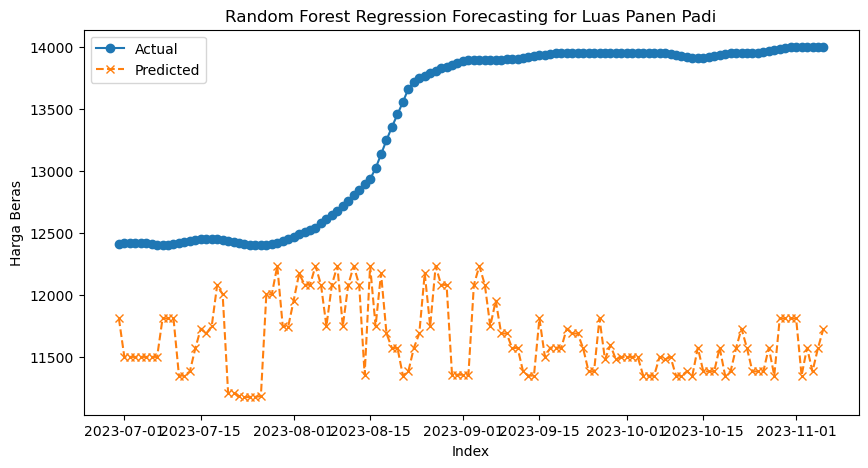

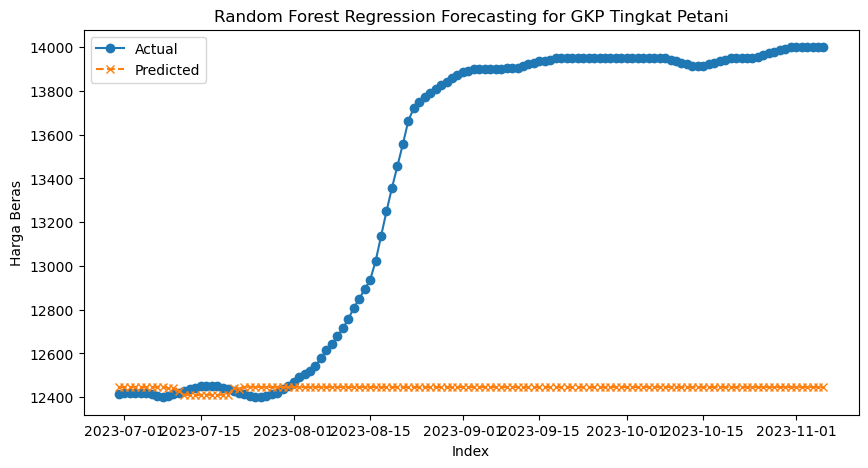

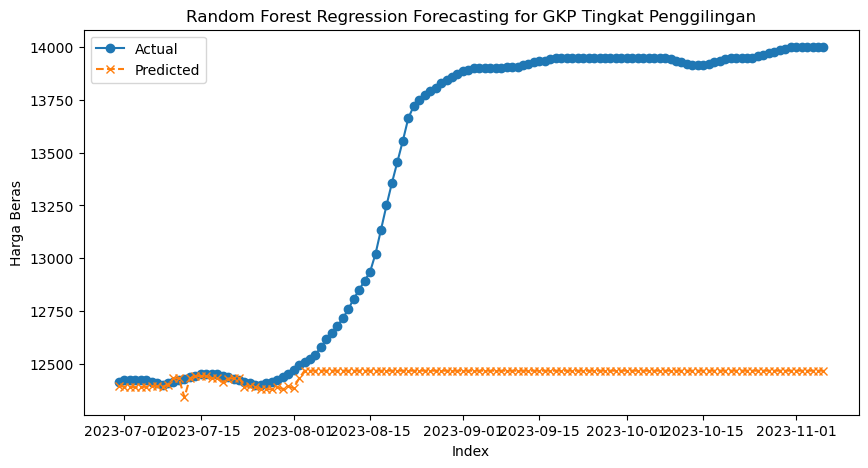

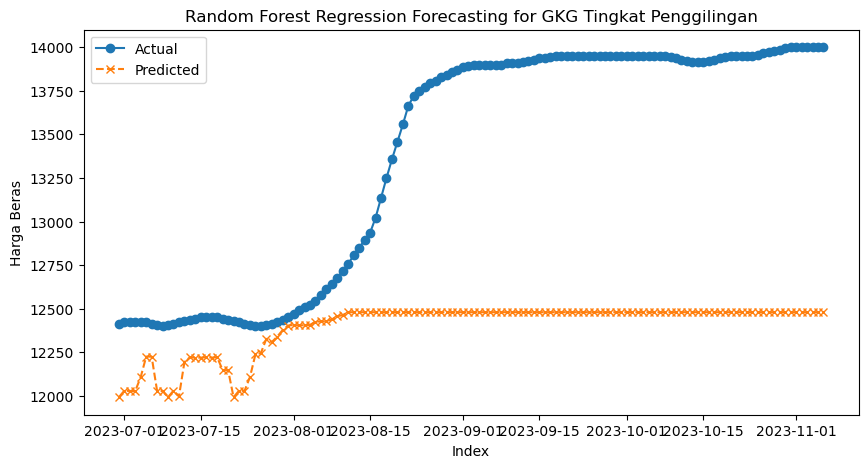

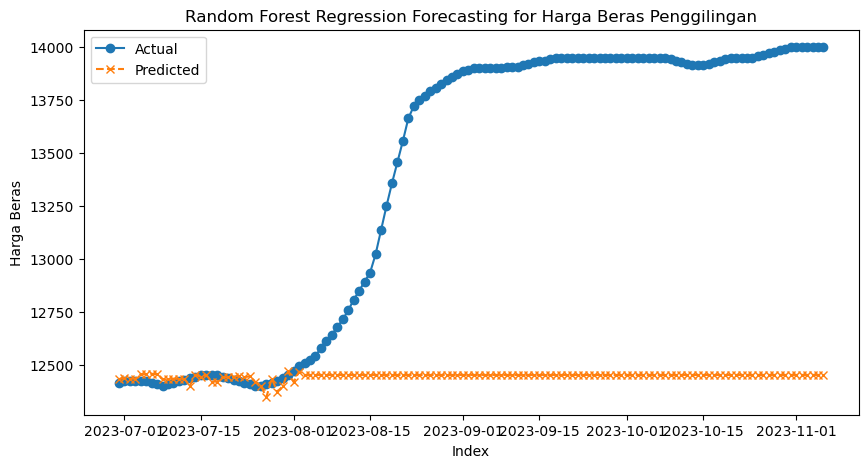

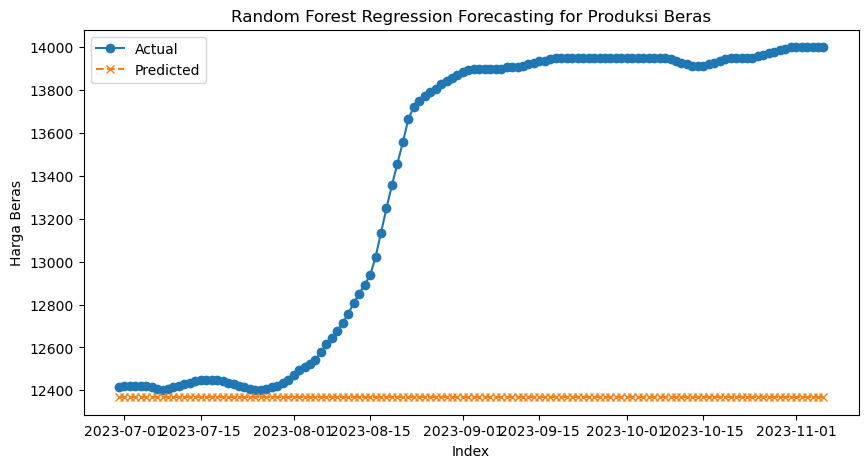

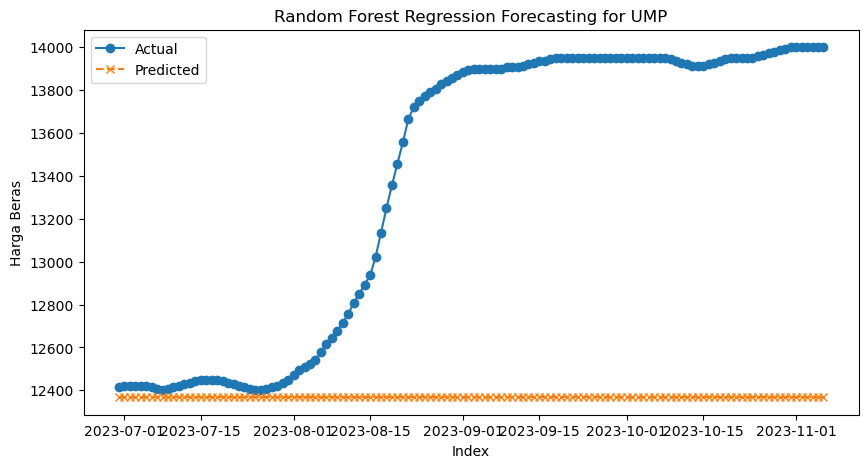

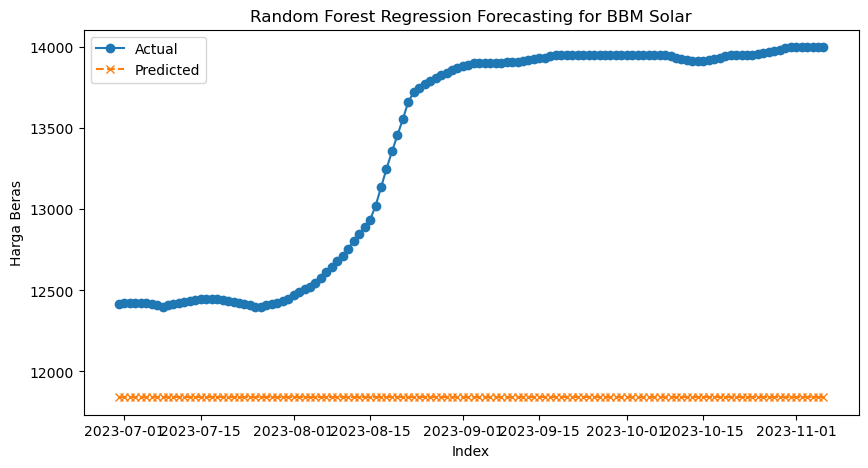

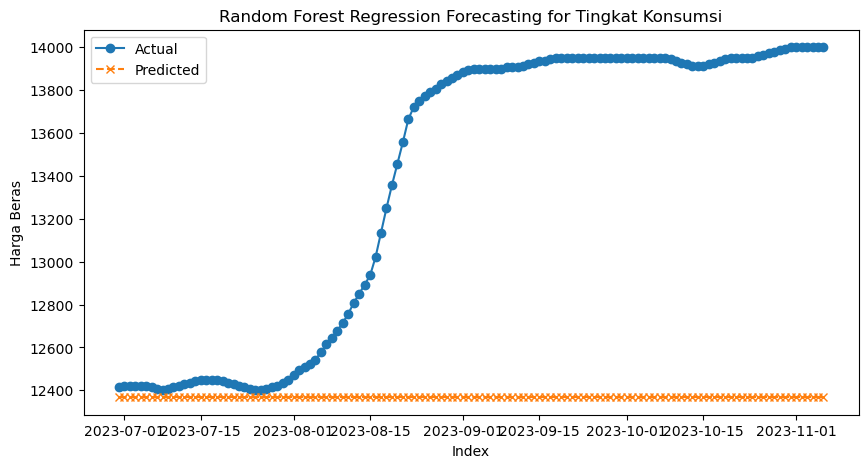

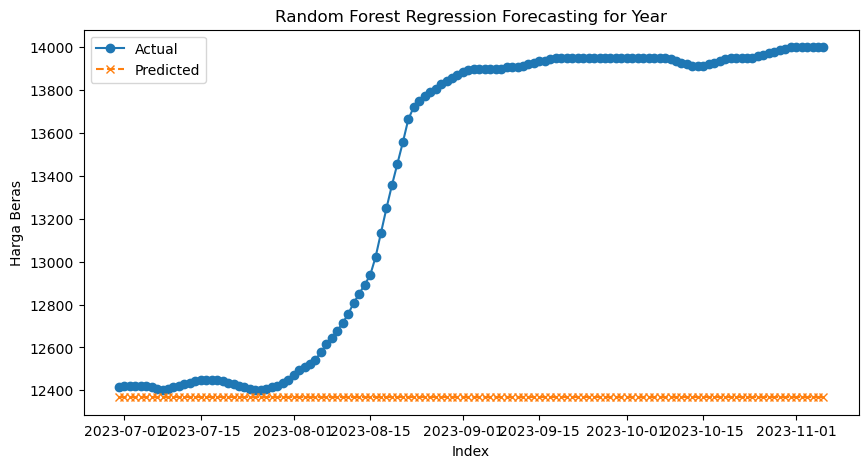

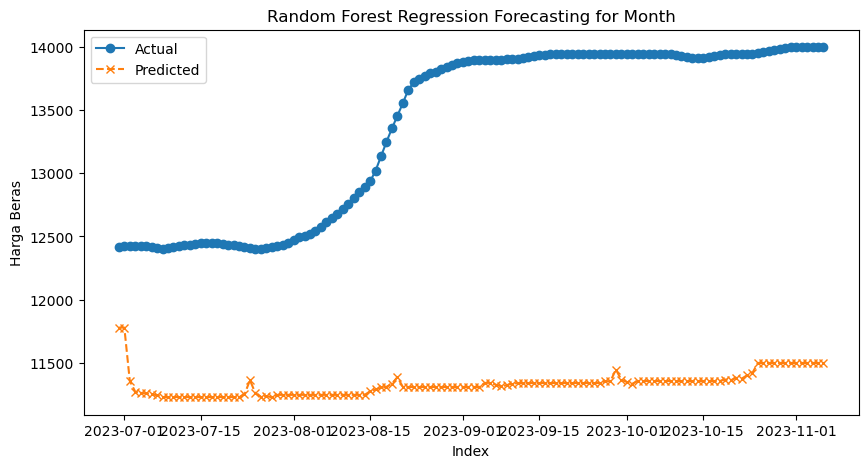

In [15]:
# Make predictions on the testing data using the best Random Forest model for each series
predictions = {col: best_rfs[col].predict(X_test_series.values.reshape(-1, 1)) for col, X_test_series in X_test.items()}

# Evaluate the model for each series
maes = {col: mean_absolute_error(y_test, predictions[col]) for col in predictions.keys()}
mses = {col: mean_squared_error(y_test, predictions[col]) for col in predictions.keys()}
rmses = {col: np.sqrt(mean_squared_error(y_test, predictions[col])) for col in predictions.keys()}

# Print the evaluation results for each series
for col in mses:
    print(f"{col} Mean Absolute Error: {maes[col]}")
    print(f"{col} Mean Squared Error: {mses[col]}")
    print(f"{col} Root Mean Squared Error: {rmses[col]}\n")

for col, X_test_series in X_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(X_test_series.index, y_test, label='Actual', marker='o')
    plt.plot(X_test_series.index, predictions[col], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Index')
    plt.ylabel('Harga Beras')
    plt.title(f'Random Forest Regression Forecasting for {col}')
    plt.legend()
    plt.show()

# Residual

In [16]:
cutoff_index = int(len(data_mod) * 0.8)

# Split each series in train_trend and test_trend into training and testing sets using the calculated index
X_train = {col: series.iloc[:cutoff_index] for col, series in train_residual.items()}
X_test = {col: series.iloc[cutoff_index:] for col, series in train_residual.items()}
y_train = test_trend.iloc[:cutoff_index]
y_test = test_trend.iloc[cutoff_index:]

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV for each series in X_train
best_rfs = {}
best_scores = {}
best_paramss = {}
for col, X_train_series in X_train.items():
    grid_search.fit(X_train_series.values.reshape(-1, 1), y_train)
    best_rfs[col] = grid_search.best_estimator_
    best_scores[col] = grid_search.best_score_
    best_paramss[col] = grid_search.best_params_

best_rfs, best_scores, best_paramss

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'Luas Panen Padi': RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'GKP Tingkat Petani': RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'GKP Tingkat Penggilingan': RandomForestRegressor(max_depth=10, min_samples_split=20, random_state=42),
  'GKG Tingkat Penggilingan': RandomForestRegressor(max_depth=10, min_samples_split=20, random_state=42),
  'Harga Beras Penggilingan': RandomForestRegressor(max_depth=10, min_samples_split=20, random_state=42),
  'Produksi Beras': RandomForestRegressor(min_samples_split=10, n_estimators=50, random_state=42),
  'UMP': RandomForestRegressor(min_samples_split=10, n_estimators=50, random_state=42),
  'BBM Solar': RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'Tingkat Konsumsi': RandomForestRegressor(n_estimators=50, random_state=42),
  'Ye

Luas Panen Padi Mean Absolute Error: 1863.2144925946732
Luas Panen Padi Mean Squared Error: 3997360.1206250372
Luas Panen Padi Root Mean Squared Error: 1999.3399212302638

GKP Tingkat Petani Mean Absolute Error: 1811.6432151871159
GKP Tingkat Petani Mean Squared Error: 3777626.5598859633
GKP Tingkat Petani Root Mean Squared Error: 1943.611730744071

GKP Tingkat Penggilingan Mean Absolute Error: 1807.6227952461334
GKP Tingkat Penggilingan Mean Squared Error: 3765014.885853716
GKP Tingkat Penggilingan Root Mean Squared Error: 1940.3646270362992

GKG Tingkat Penggilingan Mean Absolute Error: 1827.110623126067
GKG Tingkat Penggilingan Mean Squared Error: 3812346.787908127
GKG Tingkat Penggilingan Root Mean Squared Error: 1952.523184986065

Harga Beras Penggilingan Mean Absolute Error: 1831.009446869055
Harga Beras Penggilingan Mean Squared Error: 3862530.993855173
Harga Beras Penggilingan Root Mean Squared Error: 1965.3322858629206

Produksi Beras Mean Absolute Error: 1823.8900508004845
Pr

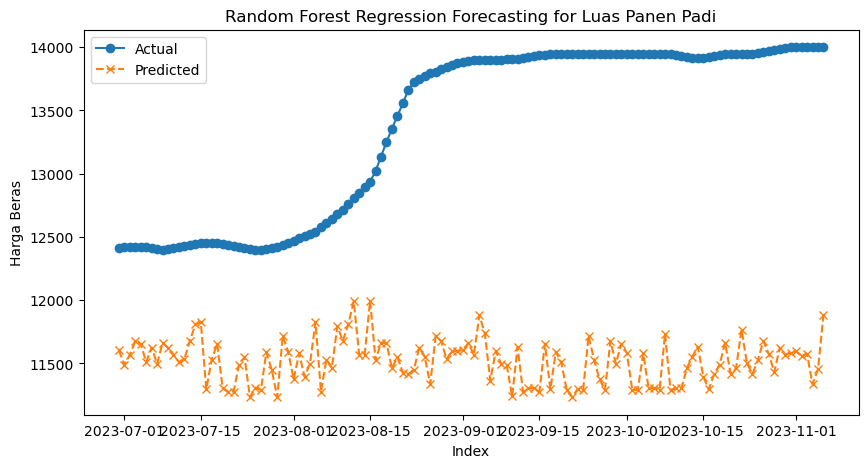

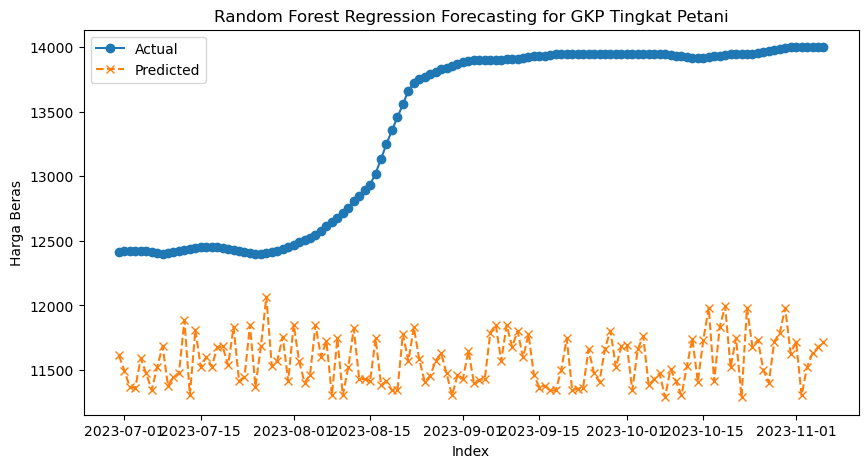

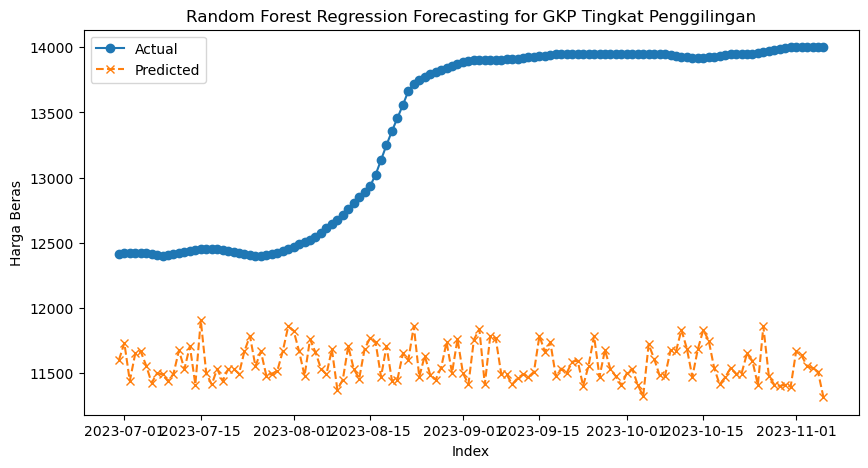

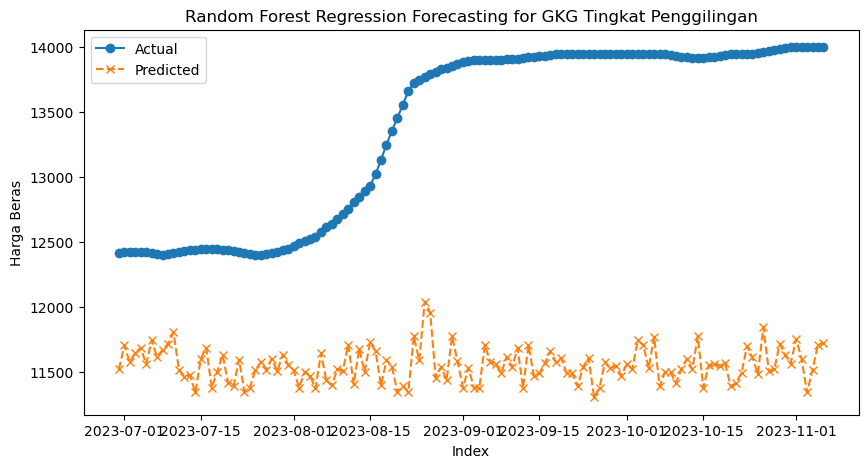

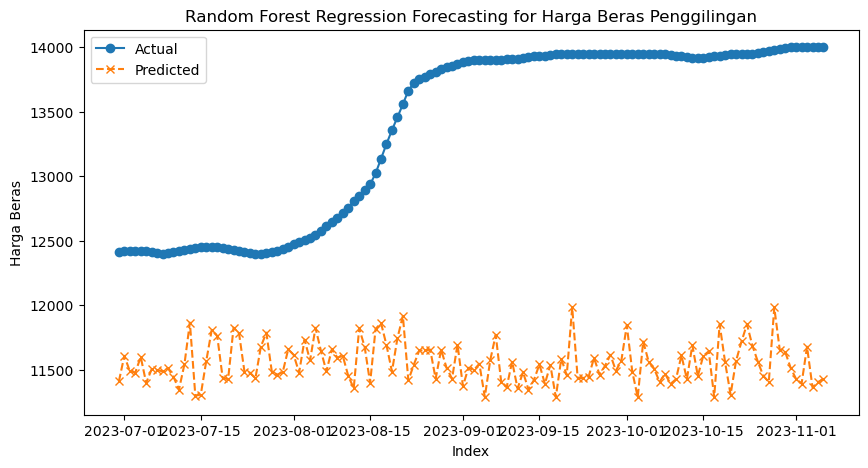

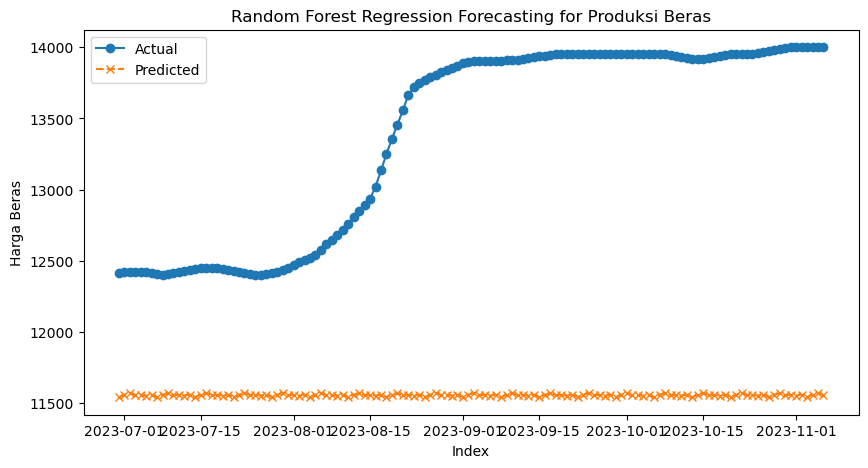

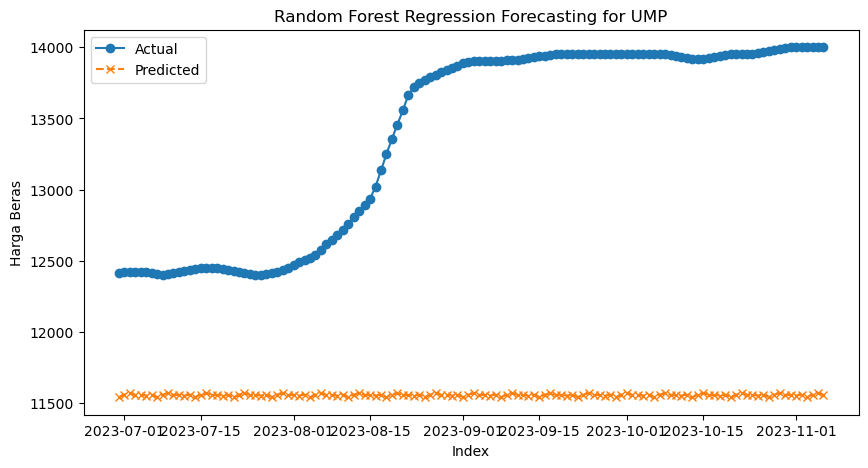

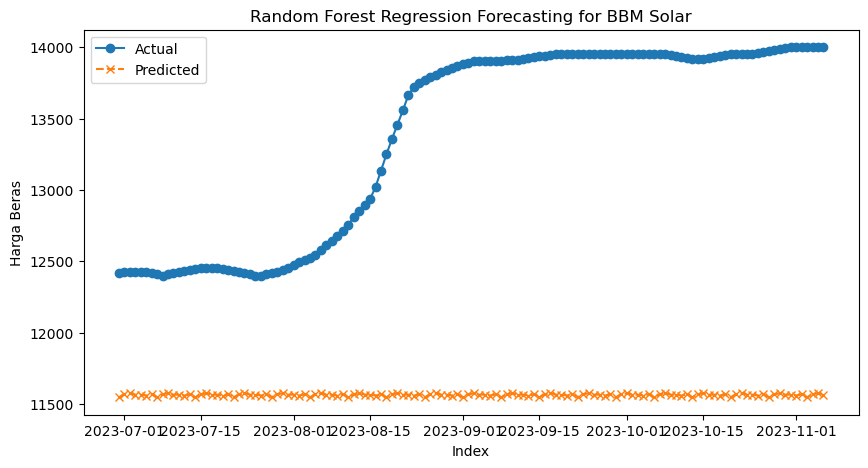

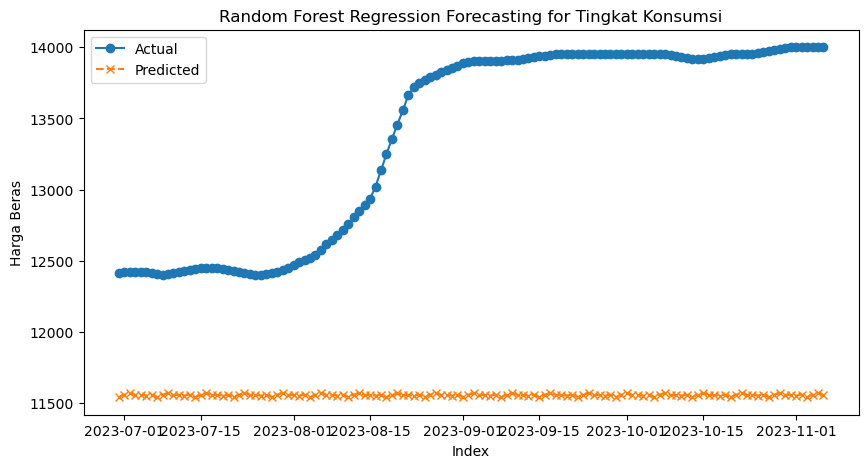

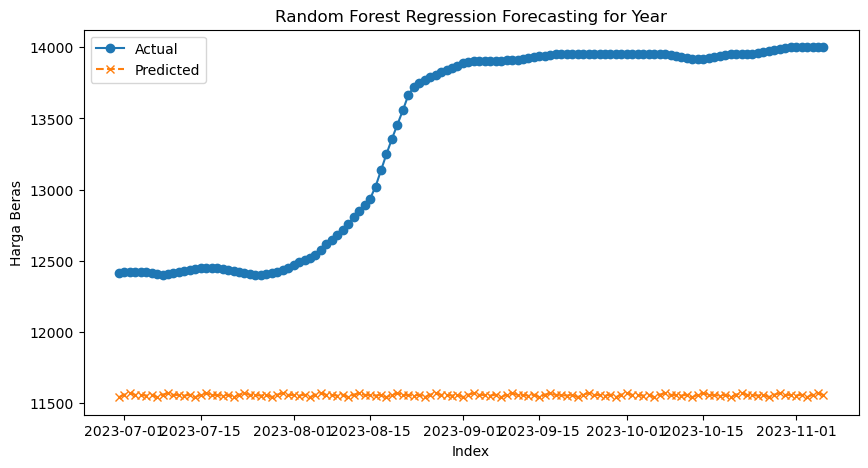

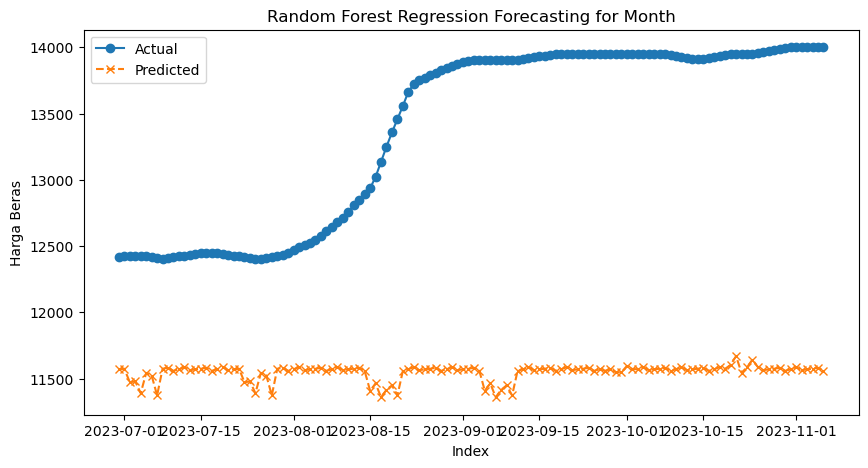

In [18]:
# Make predictions on the testing data using the best Random Forest model for each series
predictions = {col: best_rfs[col].predict(X_test_series.values.reshape(-1, 1)) for col, X_test_series in X_test.items()}

# Evaluate the model for each series
maes = {col: mean_absolute_error(y_test, predictions[col]) for col in predictions.keys()}
mses = {col: mean_squared_error(y_test, predictions[col]) for col in predictions.keys()}
rmses = {col: np.sqrt(mean_squared_error(y_test, predictions[col])) for col in predictions.keys()}

# Print the evaluation results for each series
for col in mses:
    print(f"{col} Mean Absolute Error: {maes[col]}")
    print(f"{col} Mean Squared Error: {mses[col]}")
    print(f"{col} Root Mean Squared Error: {rmses[col]}\n")

for col, X_test_series in X_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(X_test_series.index, y_test, label='Actual', marker='o')
    plt.plot(X_test_series.index, predictions[col], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Index')
    plt.ylabel('Harga Beras')
    plt.title(f'Random Forest Regression Forecasting for {col}')
    plt.legend()
    plt.show()

# Seasonal

In [19]:
cutoff_index = int(len(data_mod) * 0.8)

# Split each series in train_seasonal and test_seasonal into training and testing sets using the calculated index
X_train = {col: series.iloc[:cutoff_index] for col, series in train_seasonal.items()}
X_test = {col: series.iloc[cutoff_index:] for col, series in train_seasonal.items()}
y_train = test_trend.iloc[:cutoff_index]
y_test = test_trend.iloc[cutoff_index:]

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV for each series in X_train
best_rfs = {}
best_scores = {}
best_paramss = {}
for col, X_train_series in X_train.items():
    grid_search.fit(X_train_series.values.reshape(-1, 1), y_train)
    best_rfs[col] = grid_search.best_estimator_
    best_scores[col] = grid_search.best_score_
    best_paramss[col] = grid_search.best_params_

best_rfs, best_scores, best_paramss

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


({'Luas Panen Padi': RandomForestRegressor(n_estimators=50, random_state=42),
  'GKP Tingkat Petani': RandomForestRegressor(n_estimators=50, random_state=42),
  'GKP Tingkat Penggilingan': RandomForestRegressor(n_estimators=50, random_state=42),
  'GKG Tingkat Penggilingan': RandomForestRegressor(n_estimators=50, random_state=42),
  'Harga Beras Penggilingan': RandomForestRegressor(n_estimators=50, random_state=42),
  'Produksi Beras': RandomForestRegressor(n_estimators=50, random_state=42),
  'UMP': RandomForestRegressor(n_estimators=50, random_state=42),
  'BBM Solar': RandomForestRegressor(n_estimators=50, random_state=42),
  'Tingkat Konsumsi': RandomForestRegressor(n_estimators=50, random_state=42),
  'Year': RandomForestRegressor(n_estimators=50, random_state=42),
  'Month': RandomForestRegressor(n_estimators=50, random_state=42)},
 {'Luas Panen Padi': -334988.9078343416,
  'GKP Tingkat Petani': -334988.90783434146,
  'GKP Tingkat Penggilingan': -334988.9078343412,
  'GKG Tingkat

In [21]:
# Make predictions on the testing data using the best Random Forest model for each series
predictions = {col: best_rfs[col].predict(X_test_series.values.reshape(-1, 1)) for col, X_test_series in X_test.items()}

# Evaluate the model for each series
maes = {col: mean_absolute_error(y_test, predictions[col]) for col in predictions.keys()}
mses = {col: mean_squared_error(y_test, predictions[col]) for col in predictions.keys()}
rmses = {col: np.sqrt(mean_squared_error(y_test, predictions[col])) for col in predictions.keys()}

# Print the evaluation results for each series
for col in mses:
    print(f"{col} Mean Absolute Error: {maes[col]}")
    print(f"{col} Mean Squared Error: {mses[col]}")
    print(f"{col} Root Mean Squared Error: {rmses[col]}\n")

for col, X_test_series in X_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(X_test_series.index, y_test, label='Actual', marker='o')
    plt.plot(X_test_series.index, predictions[col], label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Index')
    plt.ylabel('Harga Beras')
    plt.title(f'Random Forest Regression Forecasting for {col}')
    plt.legend()
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [130, 136]